Plotting Growth Potential
--

**v01: move to the online DFM results**



In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, memoize
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.grid import unstructured_grid
from matplotlib import colors
import os
import numpy as np
import xarray as xr
import subprocess
from IPython.display import Video
import six
import pandas as pd
import glob
from stompy.plot import nbviz

In [3]:
run_dir="gp_tracers_v01/run_20220801T0000_20220824T0000_v02"
swim_speeds=[10] # manually transcribed from run_transport_and_swimming_v01

model = dfm.DFlowModel.load(run_dir)

ds=model.map_dataset()

In [4]:
if 0:# Checking that tracer is set on boundaries
    # Looks fine.
    fig,ax=plt.subplots()
    # How are the boundaries doing?
    #scal = ds['conc0'].isel(time=-1,laydim=-1)
    scal = ds['conc0'].isel(time=-1).compute().mean(dim='laydim')
    coll=ds.grid.plot_cells(values=scal)
    plt.colorbar(coll,label="conc0")
    coll.set_clim(0,1.5)
    ax.axis('off')
    fig.tight_layout()

Defining Growth Potential
--

Allie's definition:
$$
GP(t)=\frac{S(t)}{S_0} \frac{1}{H} \int_0^H \frac{C(z)}{C_{avg}} \exp(-K_d z) dz
$$

This estimates growth relative to growth if light were at the reference $S_0$ and
there was not any light attenuation.

I want to extend this to include a light half-saturation function, and to keep it in
growth rate units.

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \int_0^H C(z) \frac{ I_0\exp(-K_d z)}{I_{sat}+I_0\exp(-K_d z)} dz 
$$

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \int_0^H C(z) \frac{1}{\frac{I_{sat}}{I_0}\exp(K_d z)+1} dz 
$$

Take concentration to be stepwise constant in the layers (could try to be clever and
infer a continuous concentration, but would have to be careful about the surface and potential
for a SML).

$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \sum_i \left[ 
  C_i \int_{z_{i,top}}^{z_{i,bot}} \frac{1}{\frac{I_{sat}}{I_0}\exp(K_d z)+1} dz 
  \right]
$$


$$
G(t) = G_0 \frac{1}{H\ C_{avg}} \sum_i \left[ 
  C_i \left( z - \frac{1}{K_d} \log ( \frac{I_{sat}}{I_0} \exp(K_d z) + 1 ) 
  \right)_{z_{i,top}}^{z_{i,bot}}
  \right]
$$



In [5]:
from common import k_indef, kLight_m, kLight

In [6]:
Isat=30 # DS Estimate

# With Isat=40, this tops out at 0.96.
#kLight(Kd=1.55,h_min=0,h_max=3.23,I0=1000,Isat=40) # 

In [7]:
# Adding RadSurf, Kd after the fact.
@memoize.memoize()
def cimis():
    print("Reloading cimis")
    cimis_ds=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
    # Starts as PST, but the model is UTC.
    cimis_ds=cimis_ds.set_coords('time').swap_dims({'Date':'time'})
    cimis_ds['time']=cimis_ds['time']+np.timedelta64(8,'h')
    sol_rad=cimis_ds['HlySolRad'].values
    sol_rad=utils.fill_invalid(sol_rad)
    cimis_ds['sol_rad']=('time',),sol_rad
    sel = utils.select_increasing(cimis_ds.time.values)
    return 1.85*cimis_ds['sol_rad'].isel(time=sel)

In [8]:
@memoize.memoize()
def kd_on_grid(): # DataArray with nFlowElem matching ds.grid.
    print("Reloading Kd")
    kd_path="../Kd_2022/Kd_sentinel3_1h/Kd_sent3_20220801_20220901.nc"
    kd_ds=xr.open_dataset(kd_path)
    kd_grid =unstructured_grid.UnstructuredGrid.read_ugrid(kd_ds)
    _,_,cell_map = ds.grid.match_to_grid(kd_grid) # renumbering...
    
    kd_remap = kd_ds['Kd'].isel(nFlowElem = cell_map)
    return kd_remap
    
#ds.grid.plot_cells(values=kd_ds['Kd'].isel(time=50).values[cell_map], cmap='turbo',clim=[0.8,3.0])
#plt.figure()
#ds.grid.plot_cells(values=kd_remap.isel(time=50).values, cmap='turbo',clim=[0.8,3.0])

In [9]:
def add_rad(data):
    t=data['time'].values
    data['RadSurf'] = cimis().sel(time=t,method='nearest')

    if 'Kd' in data: return
        
    if ('nFlowElem' in data.dims) or ('nFlowElem' in data):
        c=data['nFlowElem']
    else:
        x=data['FlowElem_xzw']
        y=data['FlowElem_yzw']
        c=ds.grid.select_cells_nearest([x,y])
        
    data['ExtVl'] = kd_on_grid().sel(time=t,method='nearest').isel(nFlowElem=c)


In [10]:
def add_z(data):
    z_int = ((1-data['LayCoord_w'])*(data['FlowElem_bl']-data['s1'])) # .values  # relative to surface
    data['z_int']=z_int

    z_bot = z_int.isel(wdim=slice(None,-1)).rename({'wdim':'laydim'})
    data['z_bot'] = z_bot

    z_top = z_int.isel(wdim=slice(1,None)).rename({'wdim':'laydim'})
    data['z_top'] = z_top    
    data['z_mid'] = 0.5*(data['z_bot']+data['z_top'])
    data['z_bed'] = z_int.isel(wdim=0) # equiv to old -H

In [11]:
# Choose a spot off SF for developing the growth potential:
#p=[558200, 4.17271e6]
p=[565000, 4.16141e6]
#p=[536400, 4.1630e6]

g=ds.grid # unstructured_grid.UnstructuredGrid.read_ugrid(ds)
c=g.select_cells_nearest(p)

scal='conc0' # 10 m/d
tidx=429 # max sun this day
col=ds.isel(time=tidx,nFlowElem=c)
add_rad(col)
add_z(col)

INFO:multi_ugrid:Dropping NetNode_z because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkType because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetElemNode because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetElemLink because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkContour_x because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkContour_y because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink_xu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink_yu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping ElemLink because it has unselected partitioned dimensions


Reloading cimis
Reloading Kd


Avg growth:  0.09039912145639524


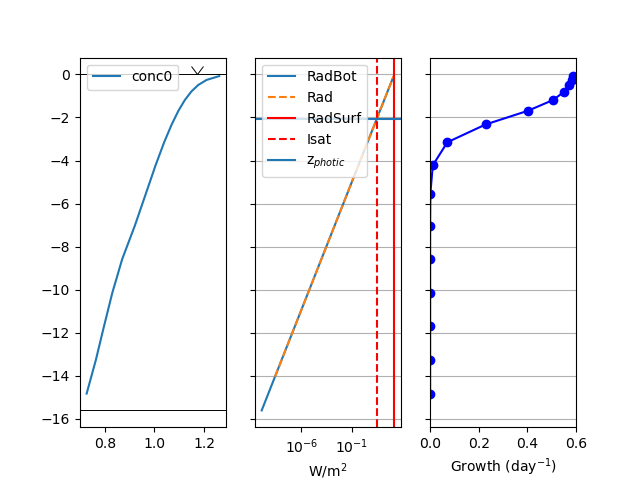

In [12]:
# original code used DWAQ output, all values positive-down, and first layer is
# surface. DFM has first layer at bed. Not exactly sigma decode, because I want 
# coordinate relative to surface, not bed.

#z_int = ((1-col['LayCoord_w'])*(col['FlowElem_bl']-col['s1'])).values  # relative to surface
#z_bot = z_int[:-1]
#z_top = z_int[1:]
#z_mid = 0.5*(z_bot+z_top)
#z_bed = z_int[0] # equiv to old -H

col['Rad']    = col['RadSurf'].values * np.exp(col.z_top*col['ExtVl'].values)
col['RadBot'] = col['RadSurf'].values * np.exp(col.z_bot*col['ExtVl'].values)

fig,(ax,axI,axG)=plt.subplots(1,3,sharey=True)
C=col[scal].values
C=C / C.mean()
ax.plot(C,col.z_mid,label=scal)
ax.axhline(0.0,color='k',lw=0.7)
ax.axhline(col.z_bed,color='k',lw=0.7)
ax.plot(0.8,0.0,marker=7,ms=8,mew=0.7,mfc='none',mec='k',
       transform=ax.get_yaxis_transform())

axI.semilogx(col['RadBot'],col.z_bot,label='RadBot')
axI.semilogx(col['Rad'],col.z_top,ls='--',label='Rad')

#RadSurf=float(col['RadSurf'])
axI.axvline( col.RadSurf, color='r', label='RadSurf')
axI.axvline( Isat, color='r',ls='--',label='Isat')
axI.axhline( -4.0 / col['ExtVl'].values, label='z$_{photic}$')

axI.set_xlabel("W/m$^2$")
ax.legend(loc='upper left')
axI.legend(loc='upper left')

# Solve the growth exactly, so we don't have to worry about interference
# from depth variation.
#  col[scal]: concentration
C_avg=float(col[scal].mean())

G0_per_day=0.3 # per day, based on upper end of R Kudela measurements. It's possible I should be using a value
# double that -- not sure if the measurements are averaged over 12h on, 12h off, or what.
G0=2*G0_per_day

extVl = col['ExtVl'].values
klight_indef=k_indef(-col.z_int.values,extVl,col['RadSurf'].values,Isat) # indexed bottom up!
# klight_indef goes from bed to surface. sort of backwards, but dividing by diff(-z_int)
# takes that into account.
seg_klight=G0*np.diff(klight_indef) / np.diff(-col.z_int)
axG.plot( seg_klight, col.z_mid,'b-o',label='Light limitation')
axG.axis(xmin=0,xmax=G0)
axG.set_xlabel('Growth (day$^{-1}$)')
# Concentration weighted average
growth_avg=G0*np.sum(col[scal]*np.diff(klight_indef)) / (col.z_bed*C_avg)
print("Avg growth: ",float(growth_avg))

#axG.set_yticks(z_int)
axG.grid(axis='y')
axI.grid(axis='y')

In [13]:
import common
six.moves.reload_module(common)

<module 'common' from '/richmondvol1/rusty/wy2022_bloom/common.py'>

In [14]:
@memoize.memoize()
def ds_col(c):
    return ds.isel(nFlowElem=c)
    
def average_growth_one(c,tidx,scal):
    col=ds_col(c).isel(time=tidx)
    
    add_z(col)
    add_rad(col)

    # manually discretized light curve
    RadSurf=float(col['RadSurf'].mean())

    # MODIFIED! Manually scale Kd by 0.5
    extVl = 0.5*float(col['ExtVl'].mean())

    C = col[scal]
    # MODIFIED!
    if 0: # enable to force no swimming
        C = C.copy()
        C.values[:] = 1.0
    C_avg=float(C.mean())

    G0_per_day=0.3 # per day, based on upper end of R Kudela measurements. It's possible I should be using a value
    # double that -- not sure if the measurements are averaged over 12h on, 12h off, or what.
    G0=2*G0_per_day

    # MODIFIED!
    klight_indef=k_indef(-col.z_int,extVl,RadSurf,Isat)
    seg_klight=np.diff(klight_indef) / np.diff(-col.z_int) # per-layer light limitation function, unitless


    # Concentration weighted average
    growth_avg=G0*np.sum(C*np.diff(klight_indef)) / (col.z_bed*C_avg)
    return dict(growth_avg=growth_avg,
                extVl = extVl,
                time=col.time.values,
                sigma=common.sigma_median(C.values), 
                RadSurf=RadSurf)
    
p=[565000, 4.16141e6]
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)
c=ds.grid.select_cells_nearest(p)

# Compile a time series for one point:
recs=[average_growth_one(c,tidx,'conc0')
      for tidx in utils.progress(range(ds.dims['time']))]
df_one = pd.DataFrame(recs)

INFO:multi_ugrid:Ragged shapes for NetElemNode, filling with 0
INFO:multi_ugrid:Ragged shapes for NetElemLink, filling with 0
INFO:multi_ugrid:Dropping NetNode_z because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkType because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetElemNode because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetElemLink because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkContour_x because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLinkContour_y because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink_xu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping NetLink_yu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping ElemLink because it has unselected partitioned dimensions
INFO:

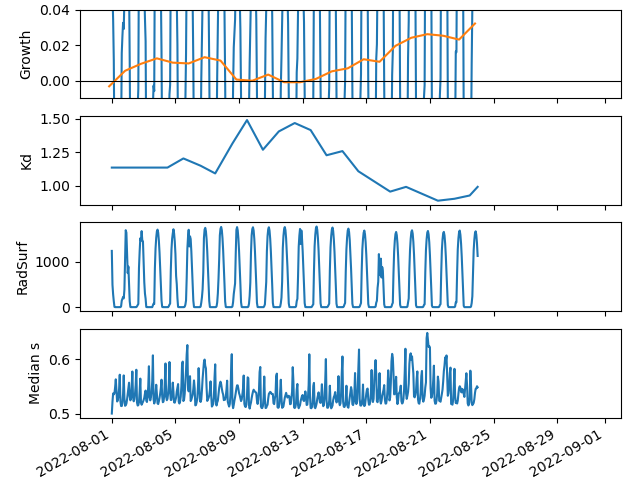

In [15]:
mort_resp=0.05

fig,axs=plt.subplots(4,1,sharex=True)
axs[0].plot(df_one.time, df_one.growth_avg - mort_resp)
# origin makes it midnight-to-midnight in PST. labels will default to start of that period.
daily_growth = df_one.set_index('time').resample('1D', origin=np.datetime64("2000-01-01 08:00"))['growth_avg'].mean()
axs[0].plot(daily_growth.index.values + np.timedelta64(12,'h'), daily_growth - mort_resp) # label by mid-day
axs[0].set_ylabel('Growth')
axs[0].axhline(0,color='k',lw=0.8)

axs[1].plot(df_one.time, df_one.extVl)
axs[1].set_ylabel('Kd')
axs[2].plot(df_one.time, df_one.RadSurf)
axs[2].set_ylabel('RadSurf')
axs[3].plot(df_one.time, df_one.sigma)
axs[3].set_ylabel('Median s')
axs[-1].set_xlim(np.datetime64("2022-08-01"), np.datetime64("2022-09-01"))

axs[-1].set_xlim(np.datetime64("2022-07-30"), np.datetime64("2022-09-02"))

axs[0].set_ylim(-0.01,0.04)

fig.autofmt_xdate()
fig.subplots_adjust(bottom=0.13,top=0.98,right=0.97)

In [31]:
Isat

30

In [161]:
def ds_compute(self,vars=None):
    if vars is None:
        vars = self.data_vars
    computed=xr.Dataset()
    for v in vars:
        computed[v] = self[v].compute()
    return computed

def growth_global(tidx,scal):
    snap=ds.isel(time=tidx) # grab data for one time step
    snap=ds_compute(snap,['conc0','LayCoord_cc','LayCoord_w','time','FlowElem_bl','s1'])
    add_z(snap)
    add_rad(snap)
    
    #h_bot=snap['LocalDepth'].values # [layer,face]
    # depth to layer interfaces, positive down.
    #h_int=np.concatenate([np.zeros_like(h_bot[:1,:]),h_bot],axis=0) # [interface,face]

    # depth-uniform values, so just pick off top layer
    #H=snap['TotalDepth'].isel(layer=0) # [face]
    
    RadSurf=snap['RadSurf'].values # [face?]
    extVl = snap['ExtVl'].values
    
    # can leave this with dimensions -- 
    C_avg=snap[scal].mean(dim='laydim')

    # I'm hoping this is a specific / instantaneous growth rate, i.e.
    # optimal light conditions, instantaneous, during daylight.
    G0_per_day=0.6 # per day, based on upper end of R Kudela measurements. 

    # add None to help broadcast against h_int
    klight_indef=k_indef(-snap.z_int.values,
                         extVl[None,:],
                         RadSurf, Isat)
    
    # Concentration weighted average
    klight_def=np.diff(klight_indef,axis=0) # solution to the per-layer definite integral
    
    if np.any(~np.isfinite(klight_def)):
        import pdb
        pdb.set_trace()
    # negative to account for reverse order of layers
    # Transpose because dwaq put layer first, but DFM puts cell first.
    growth_int=G0*np.sum(snap[scal].values.T*klight_def,axis=0) / -C_avg
    growth_int[ np.isnan(growth_int)] = 0.0 # hopefully not some other issue...
    growth_avg=growth_int/(-snap.z_bed).clip(1e-4)

    return dict(growth_avg=growth_avg,growth_int=growth_int)

growth_global(10,'conc0')

{'growth_avg': <xarray.DataArray (nFlowElem: 49996)>
 array([2.78967917e-15, 2.80819882e-14, 5.28947122e-14, ...,
        9.56145219e-16, 8.35247794e-16, 1.01940417e-15])
 Coordinates:
     time     datetime64[ns] 2022-08-01T10:00:00
     Date     <U15 '2022-08-01 0200'
 Dimensions without coordinates: nFlowElem,
 'growth_int': <xarray.DataArray 'conc0' (nFlowElem: 49996)>
 array([3.86453491e-15, 2.66453526e-16, 5.28383794e-16, ...,
        1.48571845e-14, 1.29028934e-14, 1.56627691e-14])
 Coordinates:
     time     datetime64[ns] 2022-08-01T10:00:00
     Date     <U15 '2022-08-01 0200'
 Dimensions without coordinates: nFlowElem}

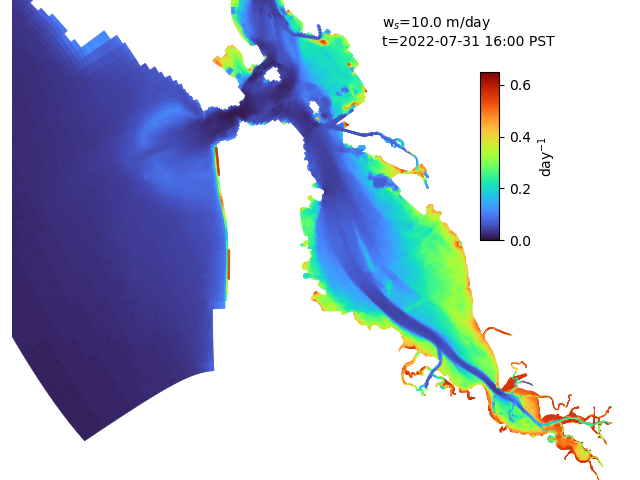

In [164]:
# Frames for instantaneous rates
scal='conc0'
ws=10.0

fig=plt.figure()
fig_dir=os.path.join( run_dir.split('/')[0], f"frames-growth-{scal}" )
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
for tidx in utils.progress(range(ds.dims['time'])):
    fig.clf()
    ax=fig.add_axes([0,0,1,1])
    growth_snap=growth_global(tidx,scal)['growth_avg']
    ax.axis('off')

    coll=ds.grid.plot_cells(values=growth_snap,cmap='turbo',clim=[0,0.65],lw=0.5,edgecolor='face')
    cax=fig.add_axes([0.75, 0.5,0.03,0.35])
    plt.colorbar(coll,cax=cax,label='day$^{-1}$')
    t_str=(ds.time.isel(time=tidx)-np.timedelta64(8,'h')).dt.strftime('%Y-%m-%d %H:%M PST').item()
    ax.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax.transAxes,va='top')
    ax.axis((517098.6559379606, 594990.8662815248, 4139373.112448552, 4200085.496536991))
    break
    fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
    plt.draw()
    plt.pause(0.01)

In [182]:
from stompy.plot import mkanim
#mkanim.mkanim("BLOOMAlg04-instant.mp4",frame_path="frames-growth-BLOOMAlg04/frame_%04d.png")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [183]:
#Video("BLOOMAlg04-instant.mp4")

In [165]:
growth_nc_fn=os.path.join(run_dir,'growth-rates-v1.nc')

In [171]:
# save them all to a dataset so we can do some averaging afterwards.
ds_growth=xr.Dataset()
ds_growth['time']=ds.time
ds_growth.attrs['dfm_run_dir']=run_dir
tracers=[scal for scal in list(ds) if scal.startswith('conc')]
ds_growth['tracers']=('tracer',),tracers
ds_growth['swim_speed']=('tracer',),swim_speeds # set at the top along with run_dir
ds_growth['swim_speed'].attrs['units']='m d-1'

ds.grid.write_xarray(ds_growth)

for scal in tracers:
    growth_avg=np.zeros( (ds.dims['time'],ds.grid.Ncells()), np.float32)
    growth_int=np.zeros( (ds.dims['time'],ds.grid.Ncells()), np.float32)
    for tidx in utils.progress(range(ds.dims['time'])):
        growth_snap=growth_global(tidx,scal)
        growth_avg[tidx,:]=growth_snap['growth_avg']
        growth_int[tidx,:]=growth_snap['growth_int']
        
    ds_growth[scal+"_avg"]=('time','face'),growth_avg
    ds_growth[scal+"_int"]=('time','face'),growth_int

ds_growth.to_netcdf(growth_nc_fn)

INFO:utils:9/478
INFO:utils:19/478
INFO:utils:28/478
INFO:utils:37/478
INFO:utils:45/478
INFO:utils:53/478
INFO:utils:61/478
INFO:utils:69/478
INFO:utils:78/478
INFO:utils:87/478
INFO:utils:95/478
INFO:utils:104/478
INFO:utils:113/478
INFO:utils:122/478
INFO:utils:132/478
INFO:utils:142/478
INFO:utils:150/478
INFO:utils:159/478
INFO:utils:168/478
INFO:utils:177/478
INFO:utils:186/478
INFO:utils:195/478
INFO:utils:204/478
INFO:utils:213/478
INFO:utils:222/478
INFO:utils:231/478
INFO:utils:240/478
INFO:utils:248/478
INFO:utils:258/478
INFO:utils:268/478
INFO:utils:278/478
INFO:utils:289/478
INFO:utils:299/478
INFO:utils:309/478
INFO:utils:318/478
INFO:utils:328/478
INFO:utils:338/478
INFO:utils:355/478
INFO:utils:378/478
INFO:utils:405/478
INFO:utils:426/478
INFO:utils:452/478
INFO:utils:477/478


INFO:utils:4
INFO:utils:8
INFO:utils:13
INFO:utils:16
INFO:utils:20


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

INFO:utils:4
INFO:utils:8
INFO:utils:11
INFO:utils:15
INFO:utils:19


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

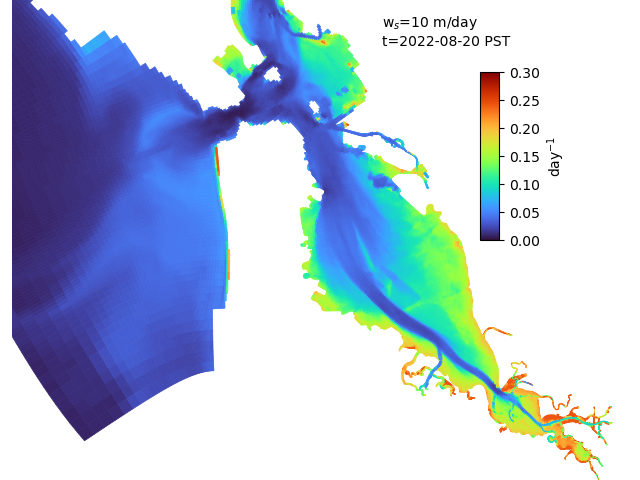

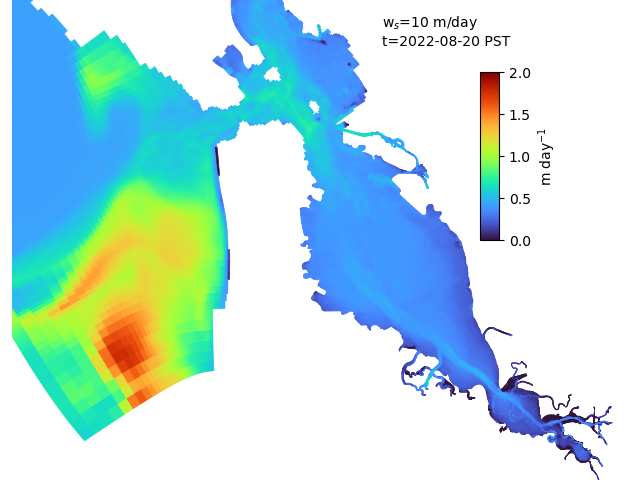

In [183]:
# Plot daily averages.
ds_growth=xr.open_dataset(growth_nc_fn)
ds_growth['time_pst']=ds_growth['time']-np.timedelta64(8,'h')
g_growth = unstructured_grid.UnstructuredGrid.read_ugrid(ds_growth)

for scal,ws in zip(tracers,swim_speeds):
    for mode in ['avg','int']:
        if mode=='avg':
            clim=[0,0.3]
        elif mode=='int':
            clim=[0,2.0]
        fig=plt.figure()

        fig_dir=os.path.join( run_dir.split('/')[0], f"frames-growth-daily-{mode}-{scal}")

        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        daily_average=ds_growth[scal+'_'+mode].groupby(ds_growth.time_pst.dt.date).mean()

        for tidx,date in utils.progress(enumerate(daily_average.date)):
            fig.clf()
            ax=fig.add_axes([0,0,1,1])
            growth_snap=daily_average.isel(date=tidx)
            ax.axis('off')

            coll=g_growth.plot_cells(values=growth_snap,cmap='turbo',clim=clim,
                                     edgecolor='face',lw=0.5)
            cax=fig.add_axes([0.75, 0.5,0.03,0.35])
            if mode=='avg':
                units='day$^{-1}$'
            elif mode=='int':
                units='m day$^{-1}$'
            plt.colorbar(coll,cax=cax,label=units)
            t_str=date.item().strftime('%Y-%m-%d PST')
                    
            ax.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax.transAxes,va='top')
            ax.axis((517098.6559379606, 594990.8662815248, 4139373.112448552, 4200085.496536991))
            fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
        
        mkanim.mkanim( os.path.join(run_dir.split('/')[0],f"{scal}-{ws}mpd-daily-{mode}.mp4"),
                      fig_dir+"/frame_%04d.png",
              fps=1)

INFO:utils:2
INFO:utils:4
INFO:utils:6
INFO:utils:8
INFO:utils:10
INFO:utils:12
INFO:utils:14
INFO:utils:16
INFO:utils:18
INFO:utils:20


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

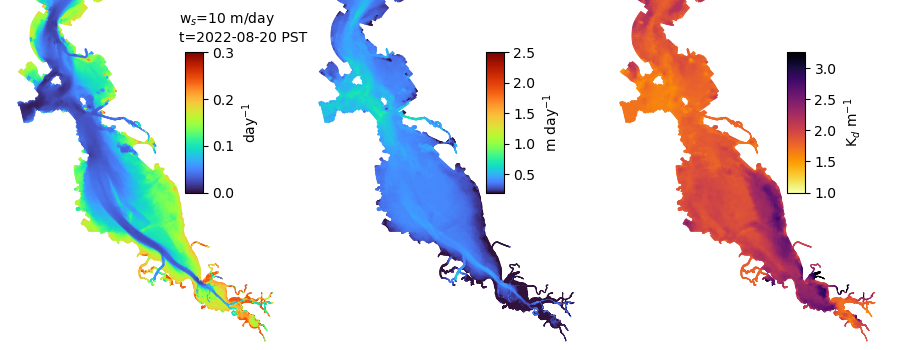

In [182]:
# triptych with depth averaged, depth-integrated, and the Kd field
from matplotlib import cm
import stompy.plot.cmap as scmap

#daily_Kd=ds['ExtVl'].isel(layer=0).groupby((ds.time-np.timedelta64(8,'h')).dt.date).mean()
#daily_Kd = kd_on_grid().groupby((ds.time-np.timedelta64(8,'h')).dt.date).mean()
#daily_Rad=ds['RadSurf'].isel(layer=0).groupby((ds.time-np.timedelta64(8,'h')).dt.date).mean()


ds_growth=xr.open_dataset(growth_nc_fn)
ds_growth['time_pst']=ds_growth['time']-np.timedelta64(8,'h')
g_growth = unstructured_grid.UnstructuredGrid.read_ugrid(ds_growth)

fig=plt.figure(figsize=(9,3.5))

zoom=(538872.022219604, 597942.8780323294, 4137242.5345184947, 4206617.972956329)
clip_point=np.r_[ 543100, 4.1843e6]
clip_normal=np.r_[1.0,0.3]
cc=g_growth.cells_center()
sel=(cc-clip_point).dot(clip_normal)>0

for scal,ws in zip(tracers,swim_speeds):
    # if ws!=15: continue # TMP
        
    fig_dir=os.path.join(run_dir.split('/')[0],f"frames-triptych-daily-{scal}")

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    daily_avg_average=ds_growth[scal+'_avg'].groupby(ds_growth.time_pst.dt.date).mean()
    daily_int_average=ds_growth[scal+'_int'].groupby(ds_growth.time_pst.dt.date).mean()

    for tidx,date in utils.progress(enumerate(daily_average.date)):
        #if tidx!=8: continue # TMP
        fig.clf()
        ax_avg=fig.add_subplot(1,3,1)
        ax_int=fig.add_subplot(1,3,2)
        ax_Kd =fig.add_subplot(1,3,3)
        for ax in [ax_avg,ax_int,ax_Kd]:
            ax.set_adjustable('datalim')
            ax.axis('off')
        fig.subplots_adjust(left=0.0,right=1.,top=1.0,bottom=0.0,wspace=0.01)
        
        for ax,data,mode in [(ax_avg,daily_avg_average,'avg'),
                             (ax_int,daily_int_average,'int'),
                             (ax_Kd, kd_on_grid(), 'Kd')]:
            if mode=='avg':
                clim=[0,0.3]
                units='day$^{-1}$'
                cmap='turbo'
                snap=data.isel(date=tidx)
            elif mode=='int':
                clim=[0.2,2.5]
                units='m day$^{-1}$'
                cmap='turbo'
                cmap=scmap.cmap_transform(cm.turbo,lambda s: s**0.7)
                snap=data.isel(date=tidx)
            elif mode=='Kd':
                clim=[1.0,3.25]
                units="K$_d$ m$^{-1}$"
                cmap='inferno_r'
                snap = kd_on_grid().sel(time=date,method='nearest') # may have some 12h bias...
            coll=g_growth.plot_cells(values=snap,cmap=cmap,clim=clim,
                                     edgecolor='face',lw=0.5,ax=ax,mask=sel)
            pos=ax.get_position()
            cax=fig.add_axes([pos.xmin+0.62*pos.width,
                              pos.ymin+0.45*pos.height,
                              0.02,pos.height*0.4])
            plt.colorbar(coll,cax=cax,label=units)
            t_str=date.item().strftime('%Y-%m-%d PST')

            ax.axis(zoom)
        ax_avg.text(0.6,0.97,f'w$_s$={ws} m/day\nt={t_str}',transform=ax_avg.transAxes,va='top')
        fig.savefig(os.path.join(fig_dir,f"frame_{tidx:04d}.png"),dpi=100)
    video_fn=os.path.join(run_dir.split('/')[0],f"{scal}-{ws}mpd-daily-triptych.mp4")
    mkanim.mkanim(video_fn,fig_dir+"/frame_%04d.png", fps=1)
    

In [313]:
video_fn

'BLOOMAlg01-0mpd-daily-triptych.mp4'

In [314]:
Video(video_fn)

In [217]:
ls frames-growth-daily-BLOOMAlg04/

frame_0000.png  frame_0007.png  frame_0014.png  frame_0021.png  frame_0028.png
frame_0001.png  frame_0008.png  frame_0015.png  frame_0022.png  frame_0029.png
frame_0002.png  frame_0009.png  frame_0016.png  frame_0023.png  frame_0030.png
frame_0003.png  frame_0010.png  frame_0017.png  frame_0024.png
frame_0004.png  frame_0011.png  frame_0018.png  frame_0025.png
frame_0005.png  frame_0012.png  frame_0019.png  frame_0026.png
frame_0006.png  frame_0013.png  frame_0020.png  frame_0027.png


Timeseries Plots
--

In [110]:
growth_nc_fn

'run_wy2022_take2_common_20220801-v006/growth-rates-v1.nc'

In [49]:
#growth_nc_fn=os.path.join(run_dir,'growth-rates.nc')
ds_growth=xr.open_dataset(growth_nc_fn)

In [50]:
import bloom_common
six.moves.reload_module(bloom_common)
ssfb_poly=bloom_common.ssfb_poly

In [53]:
growth_nc_fn

'run_wy2022_take2_common_20220801-v006/growth-rates-v1.nc'

In [65]:
face_sel=g.select_cells_intersecting(ssfb_poly)

In [93]:
H=ds['TotalDepth'].isel(layer=0).values[:,face_sel]

In [96]:
(H*Ac).shape

(1441, 15008)

In [112]:
tracers

['BLOOMAlg01', 'BLOOMAlg02', 'BLOOMAlg03', 'BLOOMAlg04', 'BLOOMAlg05']

<IPython.core.display.Javascript object>


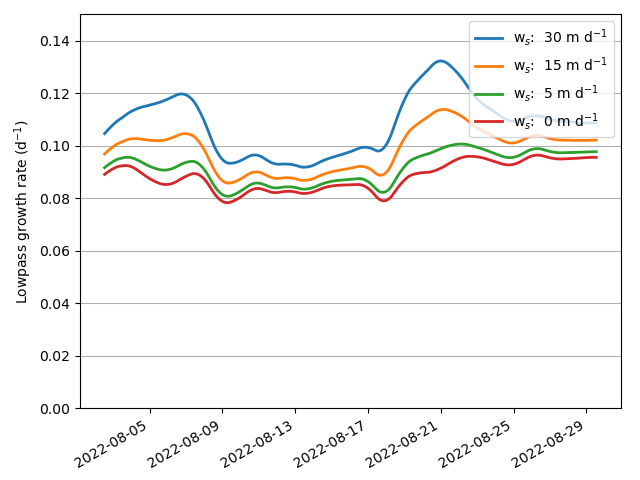

<IPython.core.display.Javascript object>


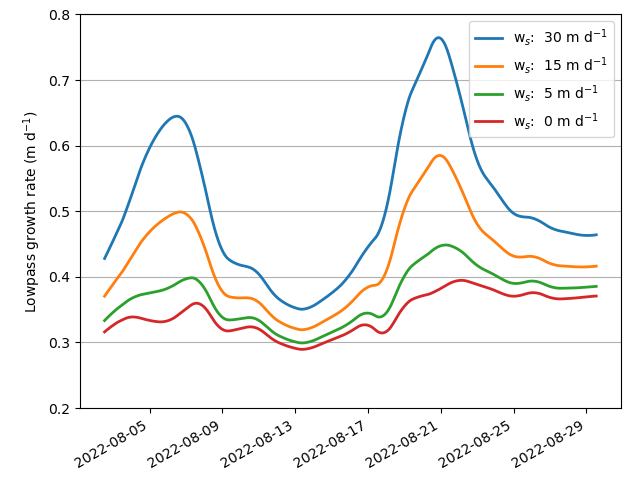

<IPython.core.display.Javascript object>


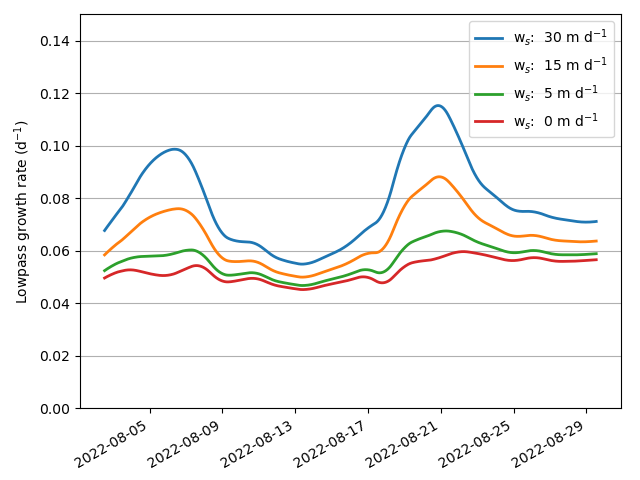

In [109]:
# area averaged time series across ssfb
from stompy import filters

Ac=g.cells_area()[face_sel]

for vert in ['avg' ,'int','vol']:
    fig,ax=plt.subplots()
    for scal,ws in zip(tracers[::-1],swim_speeds[::-1]):
        if ws>35: continue # drop 50m/d
        # start with depth-average:
        if vert=='vol':
            # t_int already includes depth, and Ac gives volume integration
            # include (H*Ac).sum() is then domain volume.
            agg_growth=(ds_growth[scal+"_int"].values[:,face_sel] * Ac).sum(axis=1) / (H*Ac).sum(axis=1) 
        else:
            tracer=scal+"_" + vert
            agg_growth=(ds_growth[tracer].values[:,face_sel] * Ac).sum(axis=1) / Ac.sum() 
        # and lowpass
        lp_agg_growth=filters.lowpass_godin(agg_growth,mean_dt_h=0.5,ends='nan')
        
        ls=ax.plot(ds_growth.time, lp_agg_growth,label="w$_s$: % 2.0f m d$^{-1}$"%ws,
                   lw=2.0)
        #ax.plot(ds_growth.time, agg_growth,label="__nolabel__",lw=0.3,alpha=0.2,
        #        color=ls[0].get_color(),zorder=-1)
    ax.legend(loc='upper right')

    if vert=='avg':
        ax.set_ylabel("Lowpass growth rate (d$^{-1}$)")
        ax.axis(ymin=0.0,ymax=0.15)
    elif vert=='vol':
        ax.set_ylabel("Lowpass growth rate (d$^{-1}$)")
        ax.axis(ymin=0.0,ymax=0.15)        
    else:
        # not sure how appropriate this is when averaged over
        # the bay.
        ax.set_ylabel("Lowpass growth rate (m d$^{-1}$)")
        ax.axis(ymin=0.2,ymax=0.8)
    fig.autofmt_xdate()
    fig.subplots_adjust(bottom=0.15,right=0.97,top=0.97)
    ax.grid(1,axis='y')
    fig.savefig(f"growth-timeseries-{vert}.png")

In [98]:
ax.axis(ymin=0.0,ymax=0.15)        


(19203.5, 19236.5, 0.0, 0.15)

In [91]:
pwd

'/richmondvol1/rusty/wy2022_bloom'